In [1]:
import pandas as pd
import os
import numpy as np
import cv2
import imghdr
import matplotlib.pyplot as plt
import tensorflow as tf


2024-03-10 22:01:17.046699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 22:01:17.046792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 22:01:17.219591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"

In [3]:
os.listdir(data_dir)

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [4]:
ext = ["img","jpeg","jpg","bmp","jpg"]

In [5]:
for image in os.listdir(data_dir):
    print(len(os.listdir(os.path.join(data_dir,image))))

2512
2382
2191
2274
2271
2404


In [6]:
for image in os.listdir(data_dir):
    for image_class in os.listdir(os.path.join(data_dir,image)):
        image_path = os.path.join(data_dir,image,image_class)
        try:
            tip = imghdr.what(image_path)
            if tip not in ext:
                os.remove(image_path)
        except:
            pass

In [7]:
for image in os.listdir(data_dir):
    print(len(os.listdir(os.path.join(data_dir,image))))

2512
2382
2191
2274
2271
2404


In [8]:
tf.keras.utils.image_dataset_from_directory??

In [9]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
data

Found 14034 files belonging to 6 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()
batch[0].max()

255.0

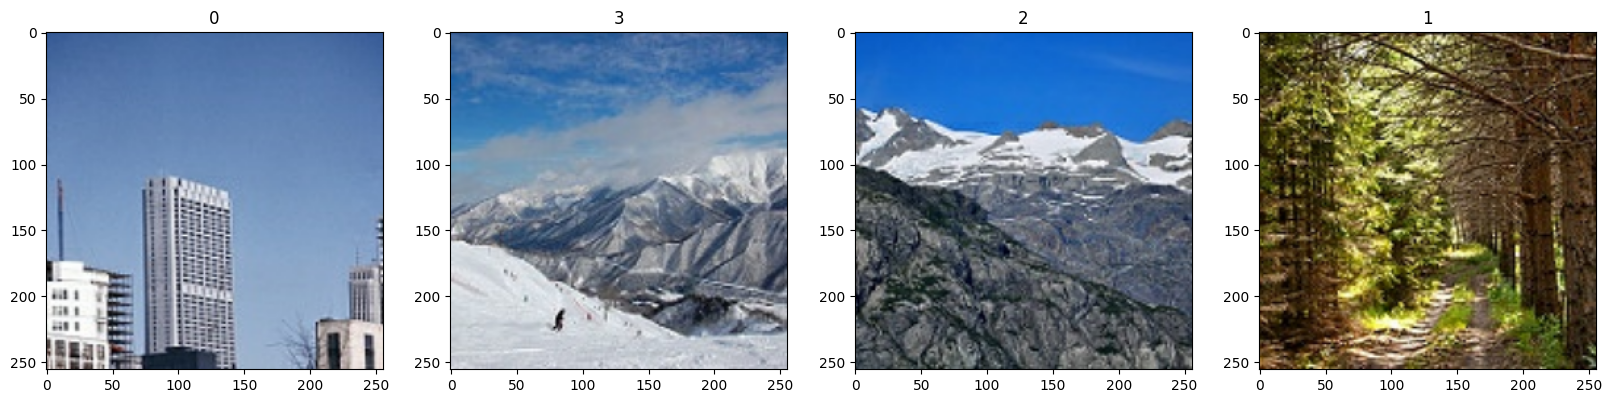

In [11]:
fig,ax = plt.subplots(ncols = 4,figsize = (20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [12]:
data = data.map(lambda x,y:(x/255 ,tf.one_hot(y,depth = 6)))

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()
batch[0][0].max()

1.0

In [13]:
# fig,ax = plt.subplots(ncols = 4,figsize = (20,20))
# for idx,img in enumerate(batch[0][:4]):
#     ax[idx].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#     ax[idx].title.set_text(batch[1][idx])

In [14]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.2)
train_size

351

In [15]:
test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test"

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,batch_size = 256)

Found 3000 files belonging to 6 classes.


In [16]:
print(len(train_data))
print(len(val_data))

print(len(test_data))

351
87
12


In [17]:
batch[0][0].shape

(256, 256, 3)

In [18]:
batch[1]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0.

In [19]:
im_size = 256

In [20]:
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,BatchNormalization,InputLayer,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler

In [21]:
model = tf.keras.Sequential()

# Convolutional layers
model.add(InputLayer(input_shape = (im_size,im_size,3)))
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax')) 

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 24,789,766 (94.57 MB)

 Trainable params: 24,770,630 (94.49 MB)

 Non-trainable params: 19,136 (74.75 KB)

In [22]:
model.compile(optimizer = Adam(learning_rate = 0.001),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [23]:
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
intial_learning_rate = 0.001

def step_decay(epoch):
    drop_rate = 0.5
    epochs_drop = 5
    return intial_learning_rate * (drop_rate ** (epoch // epochs_drop))

lr_schedule = LearningRateScheduler(step_decay)

In [24]:
# from keras.utils import to_categorical
# train_data.as_numpy_iterator().next()[1] = to_categorical()

In [25]:
history = model.fit(train_data,validation_data = val_data,epochs = 30,batch_size = 32,verbose = 1,callbacks = [early_stopping,lr_schedule])

Epoch 1/30
  3/351 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.2118 - loss: 3.3671

I0000 00:00:1710108188.479163      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710108188.501763      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3986 - loss: 2.8668

W0000 00:00:1710108210.062485      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.3988 - loss: 2.8646 - val_accuracy: 0.5018 - val_loss: 1.9025 - learning_rate: 0.0010
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.5305 - loss: 1.4684 - val_accuracy: 0.4670 - val_loss: 2.1955 - learning_rate: 0.0010
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.5902 - loss: 1.2547 - val_accuracy: 0.4429 - val_loss: 1.9664 - learning_rate: 0.0010
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.6311 - loss: 1.1715 - val_accuracy: 0.6530 - val_loss: 1.1000 - learning_rate: 0.0010
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.6643 - loss: 1.0613 - val_accuracy: 0.5697 - val_loss: 1.4284 - learning_rate: 0.0010
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.7107 - loss: 0.8330 - val_accuracy: 0.7701 - val_loss: 0.6415 - learning_rate: 5.0000e-04
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.7552 - loss: 0.

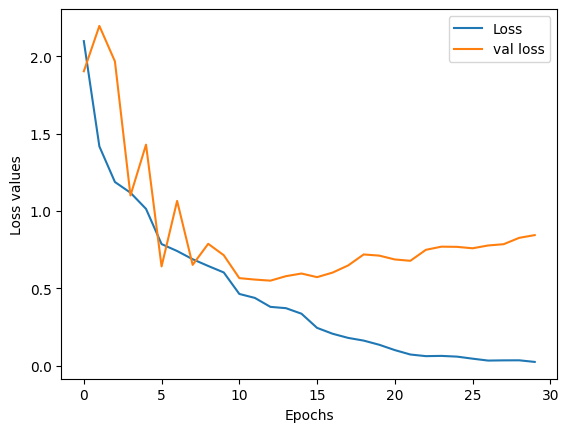

In [26]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss values")
plt.legend(["Loss","val loss"])
plt.show()

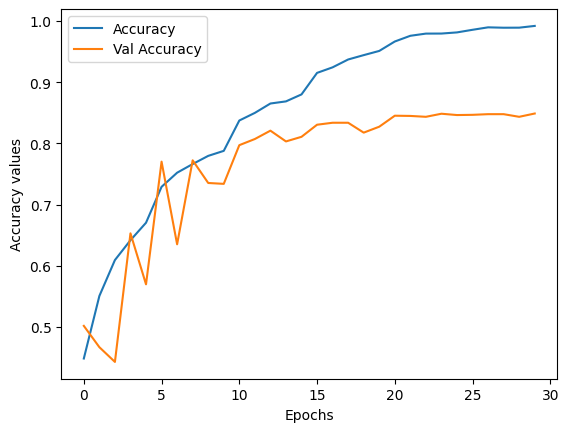

In [27]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy values")
plt.legend(["Accuracy","Val Accuracy"])
plt.show()

In [28]:
from tensorflow.keras.metrics import F1Score,Recall,Precision
pre = Precision()
re = Recall()
fscore = F1Score()

In [29]:
test_data = test_data.map(lambda x,y:(x /255, tf.one_hot(y,depth = 6)))
for batch in test_data.as_numpy_iterator():
    x,y = batch
    y_pred = model.predict(x)
    pre.update_state(y,y_pred)
    re.update_state(y,y_pred)
    fscore.update_state(y,y_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


W0000 00:00:1710108904.258530      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step


In [30]:
print(f"The precison score is {pre.result().numpy()}, recall score is {re.result().numpy()}, F1score is {fscore.result().numpy().mean()}")

The precison score is 0.8377016186714172, recall score is 0.8309999704360962, F1score is 0.8357815146446228


In [31]:
pred_dir = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"
os.listdir(pred_dir)[:4]

['6234.jpg', '22288.jpg', '20529.jpg', '21440.jpg']

In [32]:
def image_prediction(image):
    img = cv2.imread(image)
    resize = tf.image.resize(img,(256,256))
    pred = model.predict(np.expand_dims(resize/255,0))
    return pred

In [33]:
results = []
for image in os.listdir(pred_dir):
    if imghdr.what(os.path.join(pred_dir,image)) in ext and image is not None:
        y_pred = image_prediction(os.path.join(pred_dir,image))
        pred = np.argmax(y_pred)
        image_results = os.listdir("/kaggle/input/intel-image-classification/seg_train/seg_train")
        results.append(image_results[pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

In [34]:
image_names = os.listdir(pred_dir)
pred_df = pd.DataFrame(list(zip(image_names,results)),columns = ["Image","Prediction"])

In [35]:
def visualise(image):
    pred_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"
    image_path = os.path.join(pred_path,image)
    img = cv2.imread(image_path)
    return plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [36]:
pred_df

,Image,Prediction
0,6234.jpg,forest
1,22288.jpg,glacier
2,20529.jpg,sea
3,21440.jpg,mountain
4,5982.jpg,sea
...,...,...
7296,20038.jpg,glacier
7297,5303.jpg,buildings
7298,18973.jpg,buildings
7299,22292.jpg,street


In [37]:
pred_df[pred_df["Prediction"] == "forest"]

,Image,Prediction
0,6234.jpg,forest
6,2081.jpg,forest
11,9960.jpg,forest
14,9062.jpg,forest
15,4489.jpg,forest
...,...,...
7284,18528.jpg,forest
7285,18861.jpg,forest
7286,5005.jpg,forest
7288,13877.jpg,forest


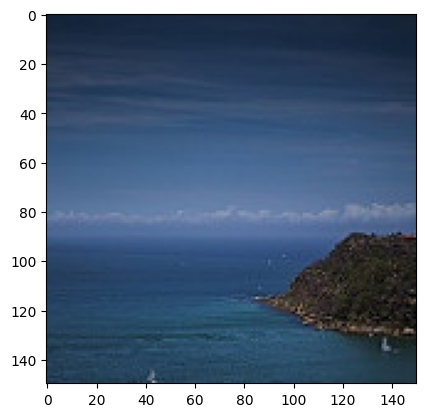

In [38]:
test_case = pred_df["Image"][:].tolist()
visualise(test_case[14])